In [87]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re

from matminer.utils.conversions import str_to_composition
from matminer.featurizers.composition import ElementProperty

In [247]:
df  = pd.read_pickle('../deliver/NIST_CeramicDataSet.pkl')
df.head()

,chemicalFormula,licenses,names,preparation,references,Axis Length,Axis Length-conditions,Axis Length-units,Bulk Modulus,Bulk Modulus-conditions,...,Thermal Expansion-conditions,Thermal Expansion-units,Thermal Shock Resistance,Thermal Shock Resistance-conditions,Thermal Shock Resistance-units,Weibull Modulus,Weibull Modulus-conditions,Weibull Strength,Weibull Strength-conditions,Weibull Strength-units
1,SiO2,[{'name': 'NIST_SRD-30'}],[Silica],NaN,"[{'citation': 'Gaseous Corrosion of Ceramics, ...",NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3Al2O3.2SiO2.xZrO2.yY2O3,[{'name': 'NIST_SRD-30'}],[Mullite composite],[{'name': 'Hot Pressing'}],[{'citation': 'Thermal Diffusivity/Conductivit...,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Al2O3,[{'name': 'NIST_SRD-30'}],[Alumina],[{'name': 'Hot Pressing'}],"[{'citation': 'Mechanical Properties of Pure, ...",NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Si3N4.xCeO2.ySiC,[{'name': 'NIST_SRD-30'}],[Silicon nitride composite],[{'name': 'Hot Pressing'}],[{'citation': 'Effect of Silicon Carbide Whisk...,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Si3N4,[{'name': 'NIST_SRD-30'}],[Silicon nitride],[{'name': 'Hot Isostatic Pressing'}],[{'citation': 'Corrosion of Silicon Nitride Ce...,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Drop non-density materials

In [223]:
# New DataFrame containing only samples with a density value
df_dens = df1[df1.isnull()['Density'] == False]

In [224]:
df_dens.shape

(398, 163)

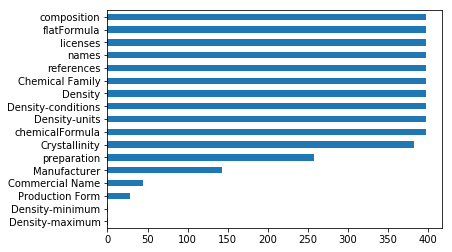

In [225]:
# Plot occurrence of features of the reduced dataset
df_dens.count().sort_values()[-17:].plot.barh()
plt.show()

In [226]:
# Drop all columns that contain less than 300 entries 
# (crystallinity is only features left with NaN)
df_dens = df_dens.dropna(axis=1, thresh=300)

### Clean up columns

#### Check if all density units are the same

In [228]:
# Check if all density units are the same, in which case we don't need the units.
df_dens['Density-units'].unique()

array(['g cm$^{-3}$'], dtype=object)

#### Fill missing crystallinity values

In [229]:
# Determine number of polycrystalline / single crystal samples
N_polyX = df_dens[df_dens['Crystallinity']=='Polycrystalline']['Crystallinity'].shape
N_singleX = df_dens[df_dens['Crystallinity']=='Single Crystal']['Crystallinity'].shape
print('Polycrystalline: {0}, Single crystal: {1}'.format(N_polyX, N_singleX))

Polycrystalline: (354,), Single crystal: (27,)


In [230]:
#Fill NaN values in crystallinity with polycrystalline:
df_dens['Crystallinity'] = df_dens['Crystallinity'].fillna('Polycrystalline')

#### Convert density to float

In [231]:
# Check how density values cannot simply be transformed from string to int

N_errors, N_total = 0, 0
for entry in df_dens['Density']:
    try:
        pd.Series([entry]).astype(float)
    except:
        N_errors +=1
        print(entry)
    finally:
        N_total +=1

print('{0} errors in {1} samples'.format(N_errors, N_total))

3.16 (1%)
1 errors in 398 samples


In [232]:
#convert the troublesome density value to a good value
df_dens.set_value(1185, 'Density', '3.16');
df_dens.loc[1185,'Density']

'3.16'

In [233]:
# Convert densities to float
df_dens['Density'] = df_dens['Density'].astype(float)

#### Remove useless columns

In [236]:
#Drop columns that don't contain numerical or categorical data
df_dens = df_dens.drop(['licenses','names','references','Density-units','Density-conditions','Chemical Family'], axis=1)
df_dens.head()

,chemicalFormula,Crystallinity,Density,flatFormula,composition,comp_int
14,Si12-4.5xAl4.5xO1.5xN16-1.5xDyx,Polycrystalline,3.30,Si11.6Al0.5O0.2N15.8D0.1,"(Si, Al, O, N, D0+)","(Si, Al, O, N, D0+)"
19,NiO,Single Crystal,6.80,Ni1.0O1.0,"(Ni, O)","(Ni, O)"
23,ZrO2,Polycrystalline,5.40,Zr1.0O2.0,"(Zr, O)","(Zr, O)"
35,WC.xCo,Polycrystalline,15.30,W1.0C1.0Co0.1,"(W, C, Co)","(W, C, Co)"
46,Si3N4,Polycrystalline,3.23,Si3.0N4.0,"(Si, N)","(Si, N)"


### Eliminate duplicate materials

In [238]:
N_unique_entries = len(df_dens['chemicalFormula'].unique())
print('There are just {0} unique entries in the {1} materials.'.format(N_unique_entries,df_dens.shape[0]))

There are just 110 unique entries in the 398 materials.


In [249]:
df_dens.sort_values('chemicalFormula').head()

,chemicalFormula,Crystallinity,Density,flatFormula,composition,comp_int
2812,$\beta$-Si3Al3O3N5,Polycrystalline,3.091,Si3.0Al3.0O3.0N5.0,"(Si, Al, O, N)","(Si, Al, O, N)"
1368,(1-x-y)Al2O3.xAlN.yTiN,Polycrystalline,4.380,Al2.0O3.0Al0.1N0.1Ti0.1N0.1,"(Al, O, N, Ti)","(Al, O, N, Ti)"
3964,0.5SiO2.(0.5-x)Al2O3.xE2O3,Noncrystalline,3.520,Si5.0O10.0Al2.0O3.0E0.2O0.3,"(Si, O, Al, E0+)","(Si, O, Al, E0+)"
3392,3Al2O3.2SiO2,Polycrystalline,3.150,Al6.0O9.0Si2.0O4.0,"(Al, O, Si)","(Al, O, Si)"
3386,3Al2O3.2SiO2,Polycrystalline,3.110,Al6.0O9.0Si2.0O4.0,"(Al, O, Si)","(Al, O, Si)"


In [251]:
df_dens = df_dens.groupby(['chemicalFormula','Crystallinity'], as_index=False).mean()

### Composition with Chih-Hao's method

In [253]:
df_feat = df_dens.copy()
df_feat.loc[3892,'chemicalFormula'] = 'BN' #fix 'B-N' to 'BN'

# Parse the chemicalFormula
def formula_decompose(formula):
    '''
    decompose chemical formula 
    return
        composition: list, [(element,num),...]
            element: string
            num: string, can be math expression such as '1+0.5x'
    '''

    comp = []
    p = re.compile(r'(\d?[w-z]?)([A-Z][a-u]?)(\d*\+?\-?\d*\.?\d*[w-z]?)')

    #split the chemical formula if there is dots, but not for cases like Mg1.5x
    if re.search(r'\.', formula) and not re.search(r'\d+\.\d[w-z]', formula): 
        formula = formula.split('.')
        for item in formula:
            prefactor = '1'
            for i in re.findall(p, item):
                pre, elem, num = i
                if pre:
                    prefactor = pre
                if num == '':
                    num = '1'
                num = prefactor + '*({})'.format(num)
                comp.append((elem, num))
    else:
        prefactor = '1'
        for i in re.findall(p, formula):
            pre, elem, num = i
            if pre:
                prefactor = pre
            if num == '':
                num = '1'
            num = prefactor + '*({})'.format(num)
            comp.append((elem, num))
    return comp 

def formula_reconstruct(composition, x=0.1, y=0.1, z=0.1, w=0.1):
    '''
    reconstruct chemical formula from composition
    composition in form of [(element,num), (element,num),...]
        element: string
        num: string, can be math expression such as '1+0.5x'

    return 
        flat chemcial formula: string, such as 'Ti1.5Cu0.1Au1.0'
    '''
    flat_list = []
    for (elem, num) in composition:
        num = re.sub(r'(\d)([w-z])', r'\1*\2', num) #convert 5x to 5*x
        flat_list.append(elem)
        flat_list.append(format(eval(num), '.1f'))
    return ''.join(flat_list)
  
def formula_parser(formula):
    return formula_reconstruct(formula_decompose(formula))

df_feat["flatFormula"] = df_feat["chemicalFormula"].map(formula_parser)
df_feat["composition"] = df_feat["flatFormula"].transform(str_to_composition)

### Composition with Chris' method

In [255]:
# Add second composition column (that doesn't have float stoichiometries; Chris' version)
def make_chem_form_compatible(formula):
    
    for bad_str in ['\.','x', 'y', '\+', '\-', 'z', 'w', '\%', '\^',   # individual characters
                 'Cordierite','hisker','Sialon', # certain words that show up in some formulas
                 '\$(.*?)\$',    # LaTeX expressions
                 '\((.*?)\)',    # bracketed expressions
                 '^\d{1,2}']:    # leading numbers of 1 or 2 digits
        formula = re.sub(bad_str, '', formula)
    
    return formula

# Convert chemical formulas using above function
df_feat["comp_int"] = df_feat["chemicalFormula"].transform(make_chem_form_compatible)

# Converting chemical formula to composition object using
# matminer.utils.conversions.str_to_composition
# which in turn uses pymatgen.core.composition
df_feat["comp_int"] = df_feat["comp_int"].transform(str_to_composition)

In [256]:
df_feat.head()

,chemicalFormula,Crystallinity,Density,flatFormula,composition,comp_int
0,$\beta$-Si3Al3O3N5,Polycrystalline,3.091000,Si3.0Al3.0O3.0N5.0,"(Si, Al, O, N)","(Si, Al, O, N)"
1,(1-x-y)Al2O3.xAlN.yTiN,Polycrystalline,4.380000,Al2.0O3.0Al0.1N0.1Ti0.1N0.1,"(Al, O, N, Ti)","(Al, O, N, Ti)"
2,0.5SiO2.(0.5-x)Al2O3.xE2O3,Noncrystalline,3.520000,Si5.0O10.0Al2.0O3.0E0.2O0.3,"(Si, O, Al, E0+)","(Si, O, Al, E0+)"
3,3Al2O3.2SiO2,Polycrystalline,3.097167,Al6.0O9.0Si2.0O4.0,"(Al, O, Si)","(Al, O, Si)"
4,3Al2O3.2SiO2.xCordierite,Polycrystalline,2.720000,Al6.0O9.0Si2.0O4.0Co0.1,"(Al, O, Si, Co)","(Al, O, Si)"


In [261]:
sample=2
print('chemical formula: ', df_feat.loc[sample,'chemicalFormula'])
print('composition :', df_feat.loc[sample,'composition'])
print('comp_int :', df_feat.loc[sample,'comp_int'])

chemical formula:  0.5SiO2.(0.5-x)Al2O3.xE2O3
composition : Si5 O13.3 Al2 E0+0.2
comp_int : Si1 O8 Al2 E0+2


### Add Additional Features with matminer

In [134]:
df_dens.shape

(398, 11)

In [135]:
df_dens_add = df_dens.copy()

In [136]:
# Add features with matminer
ep_feat = ElementProperty.from_preset(preset_name="magpie")
df_dens_add = ep_feat.featurize_dataframe(df_dens_add, col_id="composition", ignore_errors=True)

In [137]:
df_dens_add.shape

(398, 143)

In [142]:
# List of the new columns
list(set(df_dens_add.columns) ^ set(df_dens.columns))

['range GSvolume_pa',
 'range NdUnfilled',
 'mean Electronegativity',
 'mean NValence',
 'mode NValence',
 'mode SpaceGroupNumber',
 'mean NpUnfilled',
 'avg_dev Column',
 'avg_dev NsUnfilled',
 'mean CovalentRadius',
 'mean AtomicWeight',
 'mode NdValence',
 'maximum NfValence',
 'avg_dev NdValence',
 'maximum NfUnfilled',
 'mode CovalentRadius',
 'mode NfUnfilled',
 'mean NfValence',
 'maximum GSvolume_pa',
 'maximum Row',
 'avg_dev NfValence',
 'mean Column',
 'minimum NsUnfilled',
 'mean GSmagmom',
 'minimum MeltingT',
 'minimum NfUnfilled',
 'range SpaceGroupNumber',
 'minimum NValence',
 'avg_dev NValence',
 'mean NsUnfilled',
 'mean NfUnfilled',
 'maximum NValence',
 'maximum NpUnfilled',
 'avg_dev NUnfilled',
 'maximum Electronegativity',
 'minimum GSbandgap',
 'avg_dev NpUnfilled',
 'range AtomicWeight',
 'avg_dev MeltingT',
 'range NValence',
 'range Column',
 'mode MendeleevNumber',
 'range NdValence',
 'maximum AtomicWeight',
 'minimum NpValence',
 'avg_dev SpaceGroupNumber

In [144]:
df_dens_add['avg_dev Column'].head()

14         NaN
19    3.000000
23    5.333333
35    3.854875
46    0.489796
Name: avg_dev Column, dtype: float64

### Which features are numerical?

In [47]:
df1_feat.dtypes[df1_feat.dtypes!='float64']

chemicalFormula                        object
licenses                               object
names                                  object
preparation                            object
references                             object
Axis Length                            object
Axis Length-conditions                 object
Axis Length-units                      object
Bulk Modulus                           object
Bulk Modulus-conditions                object
Bulk Modulus-maximum                   object
Bulk Modulus-minimum                   object
Bulk Modulus-units                     object
Cell Angle                             object
Cell Angle-conditions                  object
Cell Angle-units                       object
Chemical Family                        object
Commercial Name                        object
Compressive Strength                   object
Compressive Strength-conditions        object
Compressive Strength-maximum           object
Compressive Strength-minimum      

In [50]:
# Exploring a non-scalar feature
df1_feat[['Thermal Expansion','Thermal Expansion-conditions','Thermal Expansion-units']].dropna()

,Thermal Expansion,Thermal Expansion-conditions,Thermal Expansion-units
43,5.9,"[{'name': 'Axis', 'scalars': [{'value': 'a'}, ...",x10$^{-6}$
89,4.6,"[{'name': 'Density', 'scalars': [{'value': '4....",x10$^{-6}$
91,3.2,"[{'name': 'Angle from Hot Press Axis', 'scalar...",x10$^{-6}$
139,10.31,"[{'name': 'Temperature Range', 'scalars': [{'m...",x10$^{-6}$
156,4.3,"[{'name': 'Temperature', 'scalars': [{'value':...",x10$^{-6}$
166,9.40,"[{'name': 'x of TiCxN1-x', 'scalars': [{'value...",x10$^{-6}$
177,4.0,"[{'name': 'Temperature', 'scalars': [{'minimum...",x10$^{-6}$
193,6.39,"[{'name': 'Temperature Range', 'scalars': [{'m...",x10$^{-6}$
201,5.1,"[{'name': 'Axis', 'scalars': [{'value': 'a'}, ...",x10$^{-6}$
202,10.8,"[{'name': 'Axis', 'scalars': [{'value': 'a'}, ...",x10$^{-6}$


In [62]:
df1_feat.loc[89,'Thermal Expansion-conditions']

[{'name': 'Density', 'scalars': [{'value': '4.53'}], 'units': 'g cm$^{-3}$'},
 {'name': 'Mole Fraction of B4C', 'scalars': [{'value': '0'}], 'units': '%'}]

In [61]:
df1_feat.loc[89,'chemicalFormula']

'TiB2.xB4C'

In [66]:
df1_feat['Compressive Strength-minimum'].dropna()

693    [8.68, 4.5, 1.9]
Name: Compressive Strength-minimum, dtype: object

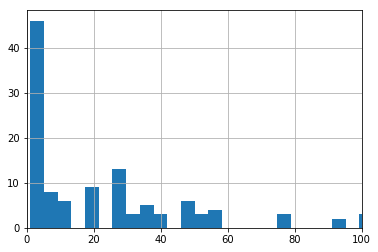

In [77]:
df.count().hist(bins=1000)
plt.xlim(0,100)
plt.show()

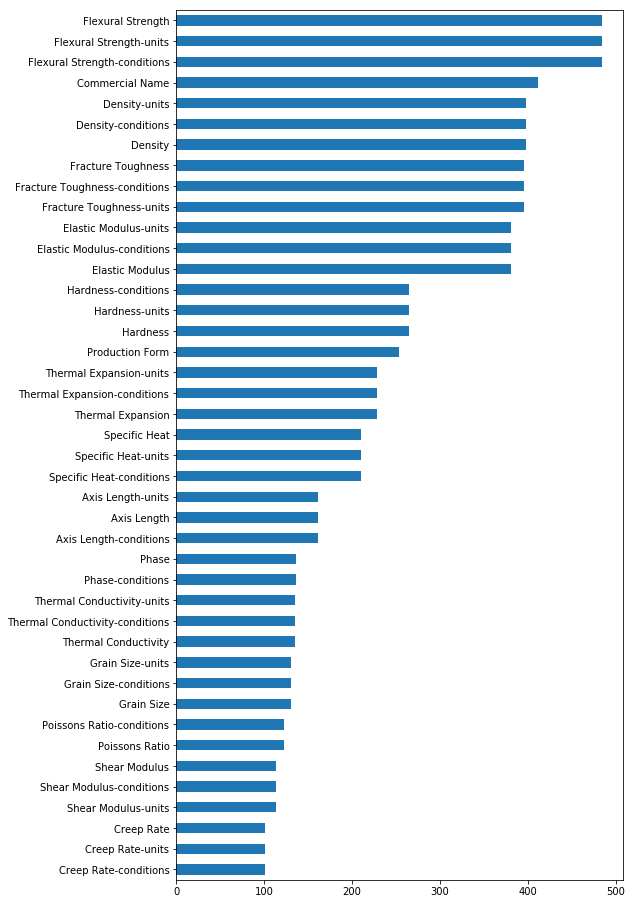

In [71]:
plt.figure(figsize=(8,16))
df.count().sort_values()[-50:-8].plot.barh()
plt.show()